In [1]:
import sys
sys.path.insert(0, '../')

In [42]:
import numpy as np
import pandas as pd
import mlflow
import optuna
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTEN, SMOTE
from src.preprocessing.preprocessing_funcs import *
from src.config.config import Columns, Paths

## Load Data

In [3]:
col = Columns()
paths = Paths()

df = pd.read_csv(paths.data_path)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## Preprocess Data

In [6]:
df[col.total_charges_col] = handle_nans(df, col.total_charges_col)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [7]:
df[col.has_internet_col] = np.where(df[col.internet_col] == 'No', 0, 1)
df[col.automatic_pay_col] = np.where(np.logical_or(df[col.payment_method_col] == 'Bank transfer (automatic)', df[col.payment_method_col] == 'Credit card (automatic)'), 1, 0)
df[col.streaming_col] = np.where(np.logical_or(df[col.streaming_tv_col] == 'Yes', df[col.streaming_movies_col] == 'Yes'), 1, 0)
df[col.support_col] = np.where((df[col.device_prot_col] == 'Yes') | (df[col.online_backup_col] == 'Yes') | (df[col.online_sec_col] == 'Yes') | (df[col.tech_support_col] == 'Yes'), 1, 0)

In [8]:
df = prepare_df_for_analysis(df)
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,has_internet,automatic_pay,streaming,has_support,InternetService_0,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year
0,7590-VHVEG,0,0,1,0,1,0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1,29.85,29.85,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0
1,5575-GNVDE,1,0,0,0,34,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,56.95,1889.50,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0
2,3668-QPYBK,1,0,0,0,2,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,53.85,108.15,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0


In [9]:
df = df.fillna(0)
y = df[col.target_col]
X = df[col.simple_cols_model]

In [10]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

## Choosing best model

In [12]:
def run_experiment(scaler, oversampler, model):
    with mlflow.start_run(run_name=f"Model:{model}, Scaler: {scaler}, Oversampler: {oversampler}"):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        accuracies, precisions = [], []
        
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if scaler == 'StandardScaler':
                scaler = StandardScaler()
            elif scaler == 'MinMaxScaler':
                scaler = MinMaxScaler()
            
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
            X_train_scaled[col.cols_to_scale] = scaler.fit_transform(X_train_scaled[col.cols_to_scale])
            X_test_scaled[col.cols_to_scale] = scaler.fit_transform(X_test_scaled[col.cols_to_scale])

            if oversampler == 'SMOTEN':
                oversampler = SMOTEN()
            elif oversampler == 'SMOTE':
                oversampler = SMOTE()
            if oversampler != 'None':
                X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_scaled, y_train)
            else:
                X_train_resampled, y_train_resampled = X_train_scaled, y_train
            
            if model == 'RF':
                model = RandomForestClassifier()
            elif model == 'LR':
                model = LogisticRegression(max_iter=1000)
            model.fit(X_train_resampled, y_train_resampled)
            y_pred = model.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            accuracies.append(accuracy)
            precisions.append(precision)

        mlflow.log_params({'scaler': scaler, 'oversampler': oversampler})
        mlflow.log_metric('accuracy', sum(accuracies) / len(accuracies))
        mlflow.log_metric('precision', sum(precisions) / len(precisions))

for scaler in ['MinMaxScaler', 'StandardScaler']:
    for oversampler in ['SMOTE', 'SMOTEN', 'None']:
        for model in ['LR', 'RF']:
            run_experiment(scaler, oversampler, model)


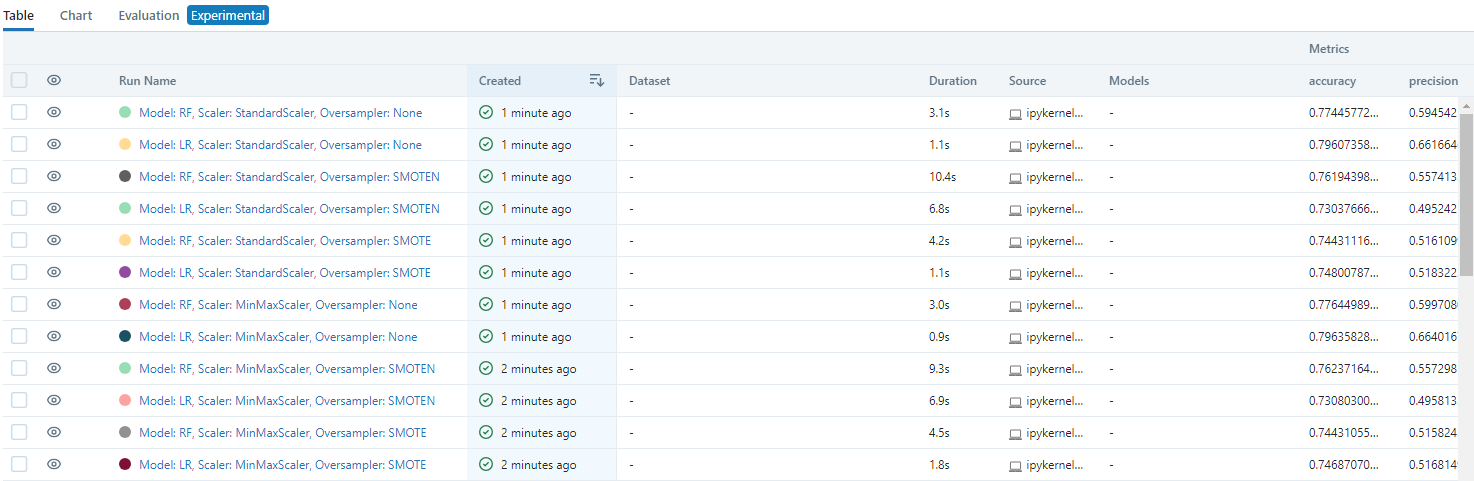


From this image we can observe that Oversamplers neither do boost accuracy nor precision score

BEST MODEL: LINEAR REGRESSION, SCALER: MINMAXSCALER, OVERSAMPLER: NONE

Now let's apply optuna to boost hyperparameters

## Hyperparameter tuning

In [18]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-5, 1e2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies, precisions = [], []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        scaler = MinMaxScaler() 
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        X_train_scaled[col.cols_to_scale] = scaler.fit_transform(X_train_scaled[col.cols_to_scale])
        X_test_scaled[col.cols_to_scale] = scaler.fit_transform(X_test_scaled[col.cols_to_scale])
        model = LogisticRegression(**params, max_iter=1000, solver='liblinear')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        accuracies.append(accuracy)
        precisions.append(precision)
    average_accuracy = sum(accuracies) / len(accuracies)
    average_precision = sum(precisions) / len(precisions)
    weighted_score = 0.3 * average_accuracy + 0.7 * average_precision
    print(f'Precision: {average_precision}, Accuracy: {average_accuracy}')
    return weighted_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2023-11-11 18:55:51,107] A new study created in memory with name: no-name-11ec636e-9862-41f6-8e75-e6f42f709d9a
[I 2023-11-11 18:55:51,329] Trial 0 finished with value: 0.6519721853494334 and parameters: {'C': 0.0008210484315598392, 'penalty': 'l1'}. Best is trial 0 with value: 0.6519721853494334.
[I 2023-11-11 18:55:51,490] Trial 1 finished with value: 0.7037837939809297 and parameters: {'C': 0.023515907904820277, 'penalty': 'l2'}. Best is trial 1 with value: 0.7037837939809297.


Precision: 0.5977100157542721, Accuracy: 0.77858391440481
Precision: 0.6641090135097023, Accuracy: 0.796358281747127


[I 2023-11-11 18:55:51,705] Trial 2 finished with value: 0.7014866175382342 and parameters: {'C': 9.494620146119606, 'penalty': 'l1'}. Best is trial 1 with value: 0.7037837939809297.
[I 2023-11-11 18:55:51,843] Trial 3 finished with value: 0.7022334930939889 and parameters: {'C': 0.36225604206442735, 'penalty': 'l2'}. Best is trial 1 with value: 0.7037837939809297.


Precision: 0.6610103525193952, Accuracy: 0.7959312359155251
Precision: 0.6620772309420173, Accuracy: 0.7959314381152558


[I 2023-11-11 18:55:52,001] Trial 4 finished with value: 0.7023608557396195 and parameters: {'C': 0.2919910985543436, 'penalty': 'l2'}. Best is trial 1 with value: 0.7037837939809297.
[I 2023-11-11 18:55:52,107] Trial 5 finished with value: 0.6508056324048603 and parameters: {'C': 0.0002189228964711969, 'penalty': 'l2'}. Best is trial 1 with value: 0.7037837939809297.


Precision: 0.6622591342501187, Accuracy: 0.7959315392151212
Precision: 0.595617028986816, Accuracy: 0.7795790403802972


[I 2023-11-11 18:55:52,330] Trial 6 finished with value: 0.7017697626418224 and parameters: {'C': 1.5224148021696473, 'penalty': 'l1'}. Best is trial 1 with value: 0.7037837939809297.
[I 2023-11-11 18:55:52,463] Trial 7 finished with value: 0.7027033604524537 and parameters: {'C': 26.409713249633054, 'penalty': 'l2'}. Best is trial 1 with value: 0.7037837939809297.


Precision: 0.6613538823056635, Accuracy: 0.7960734834261936
Precision: 0.6625655803689646, Accuracy: 0.7963581806472616


[I 2023-11-11 18:55:52,675] Trial 8 finished with value: 0.7016976909598338 and parameters: {'C': 34.34557536703761, 'penalty': 'l1'}. Best is trial 1 with value: 0.7037837939809297.


Precision: 0.6612509227599654, Accuracy: 0.7960734834261937


[I 2023-11-11 18:55:52,902] Trial 9 finished with value: 0.700700683956309 and parameters: {'C': 65.01280514521494, 'penalty': 'l1'}. Best is trial 1 with value: 0.7037837939809297.
[I 2023-11-11 18:55:53,037] Trial 10 finished with value: 0.680888350772329 and parameters: {'C': 0.0028437248070677964, 'penalty': 'l2'}. Best is trial 1 with value: 0.7037837939809297.


Precision: 0.6600093867116769, Accuracy: 0.7956470441937842
Precision: 0.6341433258191247, Accuracy: 0.7899600756631392


[I 2023-11-11 18:55:53,185] Trial 11 finished with value: 0.6932021897606924 and parameters: {'C': 0.010051374123130036, 'penalty': 'l2'}. Best is trial 1 with value: 0.7037837939809297.


Precision: 0.6506373164200276, Accuracy: 0.792520227555577


[I 2023-11-11 18:55:53,424] Trial 12 finished with value: 0.704179044249496 and parameters: {'C': 0.04232903233315246, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:53,582] Trial 13 finished with value: 0.6343620792714721 and parameters: {'C': 1.836880607377726e-05, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6646737434075387, Accuracy: 0.7963580795473961
Precision: 0.5762092579617628, Accuracy: 0.7700519956607937


[I 2023-11-11 18:55:53,757] Trial 14 finished with value: 0.7033977128751521 and parameters: {'C': 0.03939033804402336, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:53,906] Trial 15 finished with value: 0.7031690570604042 and parameters: {'C': 0.03326829675255176, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6636794388391068, Accuracy: 0.7960736856259244
Precision: 0.6634136642370118, Accuracy: 0.7959316403149868


[I 2023-11-11 18:55:54,048] Trial 16 finished with value: 0.7024835597038497 and parameters: {'C': 0.11632973964159139, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:54,176] Trial 17 finished with value: 0.6891866937871911 and parameters: {'C': 0.008853329112401926, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6624344689561041, Accuracy: 0.7959314381152559
Precision: 0.6455105691178333, Accuracy: 0.7910976513490261


[I 2023-11-11 18:55:54,339] Trial 18 finished with value: 0.7019103923529173 and parameters: {'C': 1.686999007123556, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:54,479] Trial 19 finished with value: 0.686262061042716 and parameters: {'C': 0.005638770279799171, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6616156151262584, Accuracy: 0.7959315392151213
Precision: 0.6412713424785851, Accuracy: 0.7912404043590218


[I 2023-11-11 18:55:54,629] Trial 20 finished with value: 0.7036989608958197 and parameters: {'C': 0.05127370088186313, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:54,769] Trial 21 finished with value: 0.702386645467174 and parameters: {'C': 0.06652637356689509, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6639879533736579, Accuracy: 0.7963579784475308
Precision: 0.6622961500321087, Accuracy: 0.7959311348156596


[I 2023-11-11 18:55:54,912] Trial 22 finished with value: 0.6991731329056264 and parameters: {'C': 0.01990523630542546, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:55,054] Trial 23 finished with value: 0.7029248793049135 and parameters: {'C': 0.1340765645193291, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6583142700766584, Accuracy: 0.7945104795065518
Precision: 0.6630039623101946, Accuracy: 0.7960736856259245


[I 2023-11-11 18:55:55,196] Trial 24 finished with value: 0.6822836548045836 and parameters: {'C': 0.0021401398485966414, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6357708813091403, Accuracy: 0.7908134596272852


[I 2023-11-11 18:55:55,407] Trial 25 finished with value: 0.7040644491386857 and parameters: {'C': 0.02216179199016572, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6644490295590095, Accuracy: 0.7965004281579302


[I 2023-11-11 18:55:55,626] Trial 26 finished with value: 0.6885265394485781 and parameters: {'C': 0.016588803554366906, 'penalty': 'l1'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:55,792] Trial 27 finished with value: 0.673713284885405 and parameters: {'C': 0.0010315308910317038, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6442020588062057, Accuracy: 0.7919503276141139
Precision: 0.6247463701308489, Accuracy: 0.7879694193127029


[I 2023-11-11 18:55:55,932] Trial 28 finished with value: 0.6865057842286412 and parameters: {'C': 0.0053508061220711, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:56,055] Trial 29 finished with value: 0.6522791352427959 and parameters: {'C': 0.0007045272780471423, 'penalty': 'l1'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6415585552396201, Accuracy: 0.7913826518696904
Precision: 0.5982095654778182, Accuracy: 0.7784414646944106


[I 2023-11-11 18:55:56,200] Trial 30 finished with value: 0.7024501594207861 and parameters: {'C': 0.4217475248890872, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:56,342] Trial 31 finished with value: 0.7023581720933594 and parameters: {'C': 0.06122269709927042, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6623258343756694, Accuracy: 0.7960735845260589
Precision: 0.6622554304552883, Accuracy: 0.7959312359155251


[I 2023-11-11 18:55:56,486] Trial 32 finished with value: 0.6953759244449658 and parameters: {'C': 0.01907230680269017, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:56,632] Trial 33 finished with value: 0.7038250413648748 and parameters: {'C': 0.03843233210238908, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6536817751214448, Accuracy: 0.7926622728665147
Precision: 0.6642289882197951, Accuracy: 0.7962158320367275


[I 2023-11-11 18:55:56,778] Trial 34 finished with value: 0.7031727011880688 and parameters: {'C': 0.17498368505623987, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:56,921] Trial 35 finished with value: 0.7039720654100998 and parameters: {'C': 0.026345650467278558, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6632361537911567, Accuracy: 0.7963579784475306
Precision: 0.6643780593512586, Accuracy: 0.7963580795473961


[I 2023-11-11 18:55:57,062] Trial 36 finished with value: 0.695350977357811 and parameters: {'C': 0.014540449412197919, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6535851298781377, Accuracy: 0.7928046214770489


[I 2023-11-11 18:55:57,333] Trial 37 finished with value: 0.7020291816354858 and parameters: {'C': 0.4918441692260835, 'penalty': 'l1'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:57,498] Trial 38 finished with value: 0.7027862936070624 and parameters: {'C': 0.10299326343934072, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6616635609776954, Accuracy: 0.7962156298369967
Precision: 0.6628060260703496, Accuracy: 0.7960735845260589


[I 2023-11-11 18:55:57,667] Trial 39 finished with value: 0.7031731298628642 and parameters: {'C': 0.024359562205619457, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6632975994170381, Accuracy: 0.7962160342364585


[I 2023-11-11 18:55:57,908] Trial 40 finished with value: 0.701057349848987 and parameters: {'C': 0.20077353295493053, 'penalty': 'l1'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:58,059] Trial 41 finished with value: 0.7037771371625197 and parameters: {'C': 0.03523882305428967, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6605189960725302, Accuracy: 0.7956468419940533
Precision: 0.6641605103164883, Accuracy: 0.796215933136593


[I 2023-11-11 18:55:58,198] Trial 42 finished with value: 0.6926132441319892 and parameters: {'C': 0.010052837931278149, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:58,347] Trial 43 finished with value: 0.7037486100836542 and parameters: {'C': 0.055047517281643615, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.649917891959596, Accuracy: 0.79223573253424
Precision: 0.6639979608945059, Accuracy: 0.7965001248583338


[I 2023-11-11 18:55:58,488] Trial 44 finished with value: 0.6870853728933719 and parameters: {'C': 0.0043837624203793965, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.
[I 2023-11-11 18:55:58,626] Trial 45 finished with value: 0.6906000109693511 and parameters: {'C': 0.010243539389453138, 'penalty': 'l2'}. Best is trial 12 with value: 0.704179044249496.


Precision: 0.6420817229520887, Accuracy: 0.7920938894230332
Precision: 0.6474076238975466, Accuracy: 0.7913822474702286


[I 2023-11-11 18:55:58,774] Trial 46 finished with value: 0.7046143766486705 and parameters: {'C': 0.028811623622403047, 'penalty': 'l2'}. Best is trial 46 with value: 0.7046143766486705.
[I 2023-11-11 18:55:58,918] Trial 47 finished with value: 0.7024236353494041 and parameters: {'C': 0.08625873996741534, 'penalty': 'l2'}. Best is trial 46 with value: 0.7046143766486705.


Precision: 0.6651737203972151, Accuracy: 0.7966425745687332
Precision: 0.6622879428451235, Accuracy: 0.796073584526059


[I 2023-11-11 18:55:59,096] Trial 48 finished with value: 0.6969140947620922 and parameters: {'C': 0.02706628567271303, 'penalty': 'l1'}. Best is trial 46 with value: 0.7046143766486705.
[I 2023-11-11 18:55:59,287] Trial 49 finished with value: 0.7019103923529173 and parameters: {'C': 1.2882350238811975, 'penalty': 'l2'}. Best is trial 46 with value: 0.7046143766486705.


Precision: 0.6553921487941249, Accuracy: 0.7937986353540163
Precision: 0.6616156151262584, Accuracy: 0.7959315392151213
Best Hyperparameters: {'C': 0.028811623622403047, 'penalty': 'l2'}


## Visualize & check feature importance

In [17]:
model = LogisticRegression(max_iter=1000, solver='liblinear', **study.best_params)

In [19]:
model.fit(X, y)

LogisticRegression(C=0.02778326925609085, max_iter=1000, solver='liblinear')

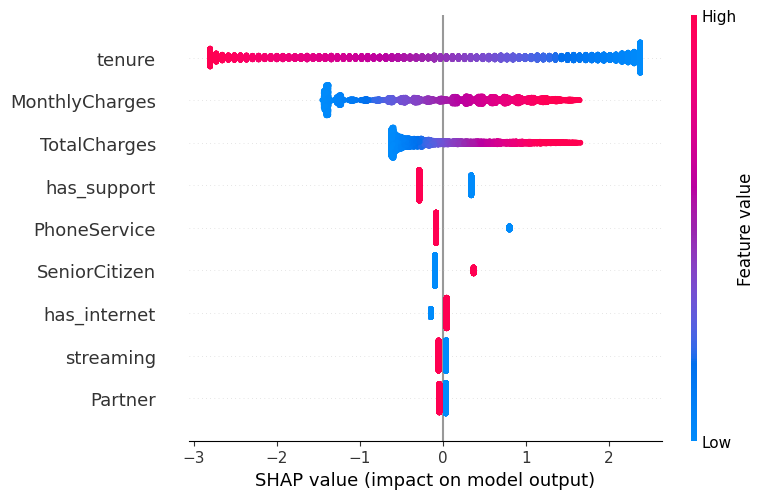

In [23]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

In [26]:
coefficients = model.coef_[0]
coefs_df = pd.DataFrame({'Feature': col.simple_cols_model, 'Coefficient': coefficients})
coefs_df = coefs_df.reindex(coefs_df['Coefficient'].abs().sort_values(ascending=False).index)
coefs_df

,Feature,Coefficient
3,PhoneService,-0.884841
6,has_support,-0.626277
7,SeniorCitizen,0.466112
4,has_internet,0.190537
5,streaming,-0.091232
8,Partner,-0.077329
0,tenure,-0.073038
2,MonthlyCharges,0.030898
1,TotalCharges,0.000264


In [32]:
y_pred = model.predict(X)
cm = confusion_matrix(y, y_pred)
cm

array([[4710,  453],
       [ 986,  883]])

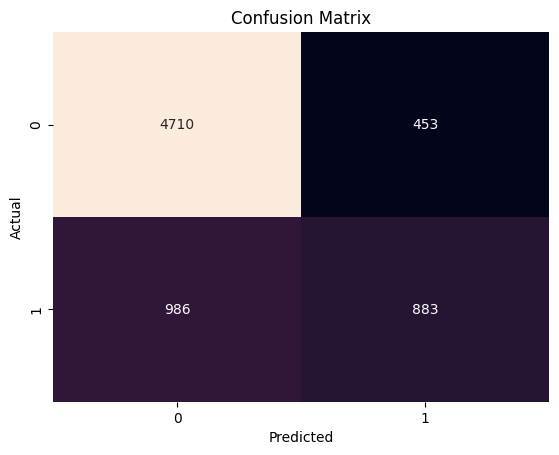

In [36]:
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

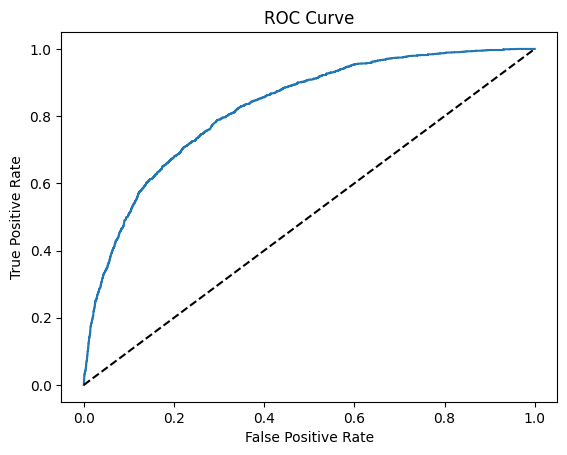

In [41]:
fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:,1])

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

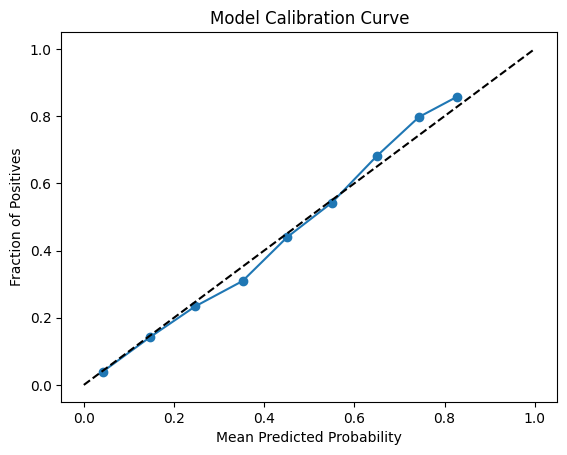

In [50]:
prob_true, prob_pred = calibration_curve(y, model.predict_proba(X)[:, 1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Model Calibration Curve')
plt.show()